In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import random
import kagglehub

In [2]:
# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

100%|██████████| 398M/398M [00:18<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [3]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations


In [4]:
ANNOTATION_PATH = '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/annotations'
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH) if filename.endswith('.xml')]

In [5]:
data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

In [6]:
df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df['label'].value_counts()

,count
label,
with_mask,3232
without_mask,717
mask_weared_incorrect,123


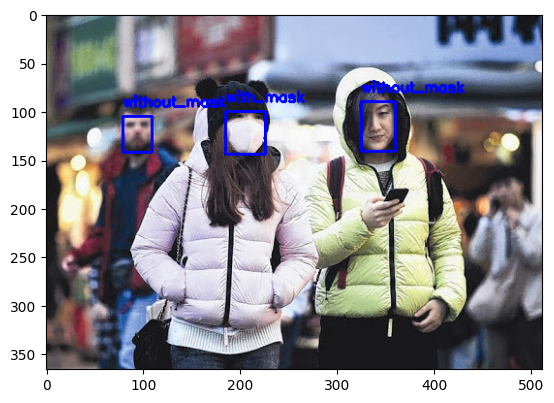

In [7]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation('/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss0.png', parse_xml('/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/annotations/maksssksksss0.xml'))


In [8]:
IMAGE_PATH = '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/'
label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

face_images = []
face_labels = []

In [9]:
for i in range(len(df)):
    row = df.iloc[i]
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    face_images.append(image)
    face_labels.append(label_pair[row['label']])

face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)

In [10]:
train_x, test_val_x, train_y, test_val_y = train_test_split(face_images, face_labels, test_size=0.3, shuffle=True, stratify=face_labels)
test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, test_size=0.5, shuffle=True, stratify=test_val_y)

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y.shape, val_y.shape, test_y.shape)

(2850, 224, 224, 3) (611, 224, 224, 3) (611, 224, 224, 3)
(2850,) (611,) (611,)


In [11]:
# Build the convolutional autoencoder
input_img = tf.keras.Input(shape=(224, 224, 3))

In [40]:
# Encoder
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

In [41]:
# Decoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

In [42]:
# Autoencoder model
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 112, 112, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 224, 224, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 224, 224, 3)         │             435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,395 (75.76 KB)

 Trainable params: 19,395 (75.76 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train the autoencoder
history_autoencoder = autoencoder.fit(train_x, train_x,
                                      epochs=10,
                                      batch_size=32,
                                      shuffle=True,
                                      validation_data=(val_x, val_x))

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - loss: 0.0663 - val_loss: 0.0063
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0010 - val_loss: 9.2286e-04
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 8.0004e-04 - val_loss: 0.0014
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 9.5961e-04 - val_loss: 8.2072e-04


In [ ]:
# Print the training history
plt.plot(history_autoencoder.history['loss'], label='train_loss')
plt.plot(history_autoencoder.history['val_loss'], label='val_loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epochs')

In [ ]:
# Save the autoencoder model
model_save_path = 'face_mask_autoencoder.h5'
autoencoder.save(model_save_path)
print(f"Model saved to {model_save_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


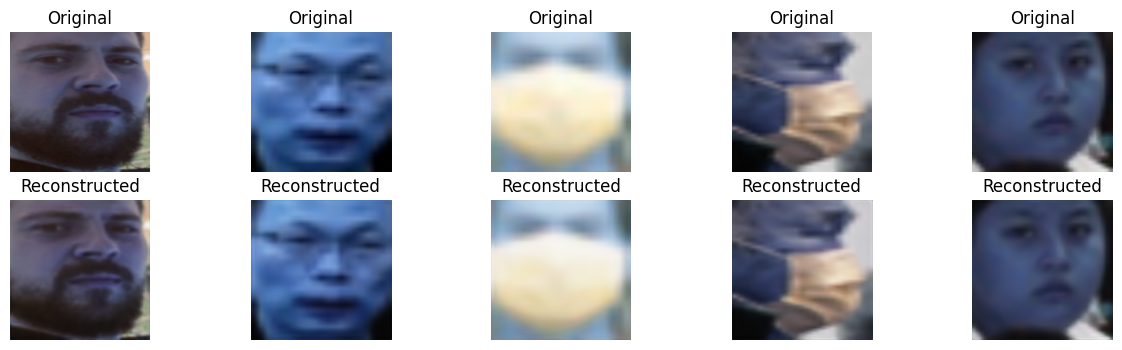

In [44]:
n = 5
sample_idxs = random.sample(range(test_x.shape[0]), n)
sample_images = test_x[sample_idxs]
reconstructed = autoencoder.predict(sample_images)

plt.figure(figsize=(15, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((sample_images[i] + 1) / 2)
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow((reconstructed[i] + 1) / 2)
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

In [45]:
# Extract the encoder model
encoder = tf.keras.Model(input_img, encoded)
encoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,088 (19.88 KB)

 Trainable params: 5,088 (19.88 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Build the classifier model using the pre-trained encoder
classifier_input = tf.keras.Input(shape=(224, 224, 3))
features = encoder(classifier_input)
x = tf.keras.layers.GlobalAveragePooling2D()(features)
x = tf.keras.layers.Dense(64, activation='relu')(x)
classifier_output = tf.keras.layers.Dense(3, activation='softmax')(x)

classifier_model = tf.keras.Model(classifier_input, classifier_output)
classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 56, 56, 32)          │           5,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,395 (28.89 KB)

 Trainable params: 7,395 (28.89 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Train the classifier using the training labels
history_classifier = classifier_model.fit(train_x, train_y,
                                          epochs=10,
                                          batch_size=32,
                                          validation_data=(val_x, val_y))

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.6962 - loss: 0.7488 - val_accuracy: 0.8347 - val_loss: 0.4560
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8515 - loss: 0.4151 - val_accuracy: 0.8789 - val_loss: 0.3784
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8881 - loss: 0.3528 - val_accuracy: 0.8903 - val_loss: 0.3564
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8805 - loss: 0.3667 - val_accuracy: 0.8903 - val_loss: 0.3567
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8802 - loss: 0.3533 - val_accuracy: 0.8920 - val_loss: 0.3463
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8969 - loss: 0.3264 - val_accuracy: 0.9002 - val_loss: 0.3382
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8870 - loss: 0.3336 - val_accuracy: 0.8854 - val_loss: 0.3590
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8862 - loss: 0.3403 - val_accuracy: 0.9018 - v

In [48]:
# Evaluate on the test set
test_loss, test_acc = classifier_model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)
print("Test accuracy:", test_acc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9063 - loss: 0.2971
Test Loss: 0.322475790977478
Test accuracy: 0.9018003344535828


In [49]:
# Generate predictions
y_pred_probs = classifier_model.predict(test_x)
y_pred = np.argmax(y_pred_probs, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [50]:
# Compare predictions with ground truth
label_map = {0: 'with_mask', 1: 'without_mask', 2: 'mask_weared_incorrect'}

print("\nClassification Report:")
print(classification_report(test_y, y_pred, target_names=label_map.values()))


Classification Report:
                       precision    recall  f1-score   support

            with_mask       0.94      0.94      0.94       485
         without_mask       0.76      0.86      0.81       108
mask_weared_incorrect       0.00      0.00      0.00        18

             accuracy                           0.90       611
            macro avg       0.56      0.60      0.58       611
         weighted avg       0.88      0.90      0.89       611



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
print("Confusion Matrix:")
cm = confusion_matrix(test_y, y_pred)
print(cm)

Confusion Matrix:
[[458  27   0]
 [ 15  93   0]
 [ 15   3   0]]


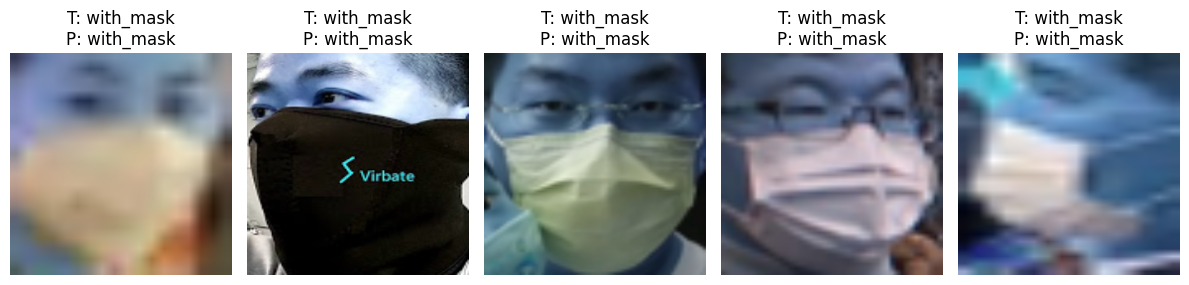

In [52]:
num_samples = 5
indices = random.sample(range(len(test_x)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow((test_x[idx] + 1) / 2)
    true_label = label_map[test_y[idx]]
    pred_label = label_map[y_pred[idx]]
    plt.title(f"T: {true_label}\nP: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()